# Imports and Support Functions

In [1]:
from keras.layers import GRU, Dense, LSTM, TimeDistributed, AlphaDropout, Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape, UpSampling2D, Normalization
from keras.layers import Flatten, Dropout, Lambda, Activation, RepeatVector, Permute, Multiply, Resizing, Concatenate, GlobalAveragePooling2D
from keras.models import Sequential, Model, load_model
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras.losses import Huber
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import joblib
from keras.saving import register_keras_serializable
import os
from keras.regularizers import l2
import numpy as np
import soundfile as sf
import time
import librosa
import matplotlib.pyplot as plt
from all_models import *

In [2]:
def mfcc_mean_extractor(file_name, n_mfcc=20):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_features

In [10]:
def pad_array(array, max_len, pad_value=0):
    current_len = array.shape[1]  # Assuming mfcc_all contains 2D arrays
    if current_len < max_len:
        pad_width = ((0, 0), (0, max_len - current_len))
        padded_array = np.pad(array, pad_width, mode='constant', constant_values=pad_value)
        return padded_array
    else:
        return array

In [2]:
def mfcc_extractor(file_name, n_mfcc=20, pad_len=None):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    if pad_len is not None:
        mfccs_features = pad_array(mfccs_features, pad_len)
    return mfccs_features

# Data and Preprocessing

In [2]:
X = joblib.load('mfcc_all/indian_mfcc_all_data.pkl')
y = joblib.load('mfcc_all/british_mfcc_all_data.pkl')

In [6]:
X.shape

(1484, 20, 229)

In [7]:
y.shape

(1484, 20, 229)

In [3]:
n_mfcc = X.shape[1]

In [4]:
max_len = X.shape[-1]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (1113, 20, 229)
Shape of y_train: (1113, 20, 229)
Shape of X_test: (371, 20, 229)
Shape of y_test: (371, 20, 229)


In [6]:
input_normalization_layer = Normalization(axis=1)
output_normalization_layer = Normalization(axis=1)
input_normalization_layer.adapt(X_train)
output_normalization_layer.adapt(y_train)

In [7]:
y_var = output_normalization_layer.variance.numpy().reshape(n_mfcc,1)
y_mean = output_normalization_layer.mean.numpy().reshape(n_mfcc,1)

In [9]:
X_train = input_normalization_layer(X_train)
X_test = input_normalization_layer(X_test)
y_train = output_normalization_layer(y_train)
y_test = output_normalization_layer(y_test)

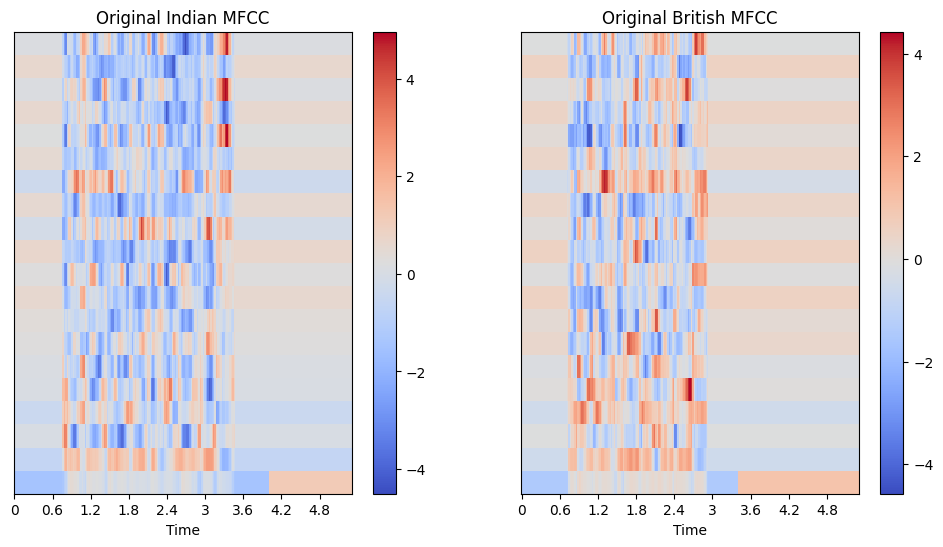

In [15]:
i = 200

# Plot original waveform
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Indian MFCC')
librosa.display.specshow(np.array(X_train[i]),sr=22050, x_axis='time')
plt.colorbar()


# Plot reconstructed waveform
plt.subplot(1, 2, 2)
plt.title('Original British MFCC')
librosa.display.specshow(np.array(y_train[i]),sr=22050, x_axis='time')
plt.colorbar()

plt.show()


# Model Constructions

In [10]:
n,c,d = X_train.shape

In [11]:
input_shape = (c, d, 1)

In [12]:
input_shape

(20, 229, 1)

In [13]:
batch_size = 32
epochs = 1000
huber_delta = 0.45

In [14]:
@register_keras_serializable()
def custom_accent_conversion_loss(alpha=0.7, beta=1.0):
    """
    Custom loss function for accent conversion.
    
    Parameters:
        alpha (float): Weight parameter for the spectral loss component.
        beta (float): Weight parameter for the adversarial loss component.
    
    Returns:
        loss_function: Custom loss function.
    """
    
    def spectral_loss(y_true, y_pred):
        """
        Spectral loss function (e.g., L1 or L2 loss).
        
        Parameters:
            y_true: Ground truth spectral features.
            y_pred: Predicted spectral features.
        
        Returns:
            loss: Spectral loss.
        """
        # Calculate spectral loss (e.g., L1 loss)
        loss = K.mean(K.abs(y_true - y_pred))  # L1 loss
        
        return loss
    
    def adversarial_loss(y_true, y_pred):
        """
        Adversarial loss function (e.g., binary cross-entropy loss).
        
        Parameters:
            y_true: Ground truth labels (real or fake).
            y_pred: Predicted labels (discriminator output).
        
        Returns:
            loss: Adversarial loss.
        """
        # Calculate adversarial loss (binary cross-entropy)
        loss = K.mean(K.binary_crossentropy(y_true, y_pred))
        
        return loss
    
    def total_loss(y_true, y_pred):
        """
        Total loss combining spectral and adversarial losses.
        
        Parameters:
            y_true: Ground truth spectral features.
            y_pred: Predicted spectral features.
        
        Returns:
            loss: Total loss.
        """
        # Calculate spectral loss
        spec_loss = spectral_loss(y_true, y_pred)
        
        # Calculate adversarial loss
        adv_loss = adversarial_loss(y_true, y_pred)
        
        # Combine spectral and adversarial losses
        loss = alpha * spec_loss + beta * adv_loss
        
        return loss
    
    return total_loss

In [15]:
model = build_autoencoder_gru(input_shape)

Encoder Conv2D 1: (None, 20, 229, 1024)
Encoder MaxPooling2D 1: (None, 10, 115, 1024)
Encoder Conv2D 2: (None, 10, 115, 512)
Encoder MaxPooling2D 2: (None, 5, 58, 512)
Encoder Conv2D 3: (None, 5, 58, 256)
(None, 3, 29, 256)
Encoder MaxPooling2D 3: (None, 16)
Decoder Conv2D 1: (None, 1, 1, 256)
Decoder UpSampling2D 1: (None, 2, 2, 256)
Decoder Conv2D 2: (None, 2, 2, 512)
Decoder UpSampling2D 2: (None, 4, 4, 512)
Decoder Conv2D 3: (None, 4, 4, 1024)
Decoder UpSampling2D 3: (None, 4, 4, 1024)
Dense layer: (None, 4580)
Output after reshaping:  (None, 20, 229, 1)


In [16]:
save_name = f'build_autoencoder_gru_dropout_skip_{epochs}.keras'

In [56]:
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])

In [57]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 20, 229, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 20, 229, 1024)  │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 20, 229, 1024)  │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 10, 115, 1024)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 10, 115, 512)   │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 10, 115, 512)   │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 5, 58, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 5, 58, 256)     │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 5, 58, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 3, 29, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_22 (Reshape)            │ (None, 87, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 87, 16)         │        13,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_23 (Reshape)            │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 1, 1, 256)      │        37,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_21 (UpSampling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_22 (UpSampling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 4, 4, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 4, 4, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │             

 Total params: 17,619,364 (67.21 MB)

 Trainable params: 17,612,196 (67.19 MB)

 Non-trainable params: 7,168 (28.00 KB)

In [ ]:
# Define ModelCheckpoint callback to save the best weights during training

tl_checkpoint_1 = ModelCheckpoint(
    filepath=f'/models/mfcc_all/{save_name}',
    save_best_only=True,  # Save only the best model weights
    verbose=1
)

In [ ]:
# Define EarlyStopping callback to stop training when validation loss stops improving

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,  # Restore best model weights upon early stopping
    mode='min'
)

In [ ]:
# Train the model
training_history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[tl_checkpoint_1, early_stop])

Epoch 1/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1.1764 - mean_absolute_error: 0.6247
Epoch 1: val_loss improved from inf to 0.99418, saving model to /models/mfcc_all/build_autoencoder_gru_skip_glorot_1000.keras

Epoch 1/112
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - loss: 1.1728 - mean_absolute_error: 0.6236 - val_loss: 0.9942 - val_mean_absolute_error: 0.6234
Epoch 2/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.9432 - mean_absolute_error: 0.5597
Epoch 2: val_loss improved from 0.99418 to 0.94717, saving model to /models/mfcc_all/build_autoencoder_gru_skip_glorot_1000.keras

Epoch 2/112
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.9427 - mean_absolute_error: 0.5596 - val_loss: 0.9472 - val_mean_absolute_error: 0.6021
Epoch 3/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.9009 - mean_absolute_error: 0.5486
Epoch 3: val_loss improved from 0.94717 to 0.93135, saving model to /models/mfcc_all/build_autoencoder_gru_skip_glorot_1000.keras

Epoch 3/112

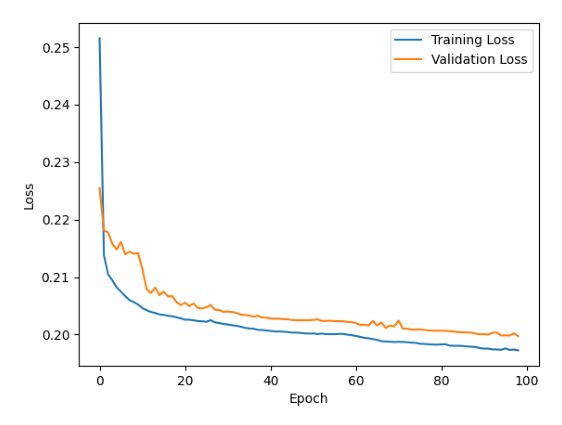

In [5]:
# Plot training loss and validation loss
plt.plot(training_history.history['loss'][10:], label='Training Loss')
plt.plot(training_history.history['val_loss'][10:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'graphs/mfcc/{'.'.join(save_name.split('.')[:1]+['png'])}')
plt.show()

In [438]:
model.save('models/mfcc_all/' + save_name)

In [137]:
custom_objects={'total_loss':custom_accent_conversion_loss}

# Model Evaluation

In [484]:
model = load_model('models/mfcc_all/' + save_name)

In [485]:
test_file = r'E:\VSCode\Applied-ML\Project\Accent_classification_accentdb\accentdb_extended\data\indian\speaker_01\indian_s01_012.wav'

In [486]:
max_len=229

In [487]:
test_mfcc = mfcc_extractor(test_file, pad_len=max_len)

In [488]:
test_mfcc_normalized = np.array(input_normalization_layer(test_mfcc))

In [489]:
if len(test_mfcc_normalized.shape)==2:
    a,b = test_mfcc_normalized.shape
elif len(test_mfcc_normalized.shape)==3:
    _,a,b = test_mfcc_normalized.shape

In [490]:
a,b

(20, 229)

In [491]:
test_prediction = model.predict(test_mfcc_normalized.reshape(1,a,b,1))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


In [492]:
test_prediction_mfcc = test_prediction.reshape(a,b)

In [493]:
sr = 22050

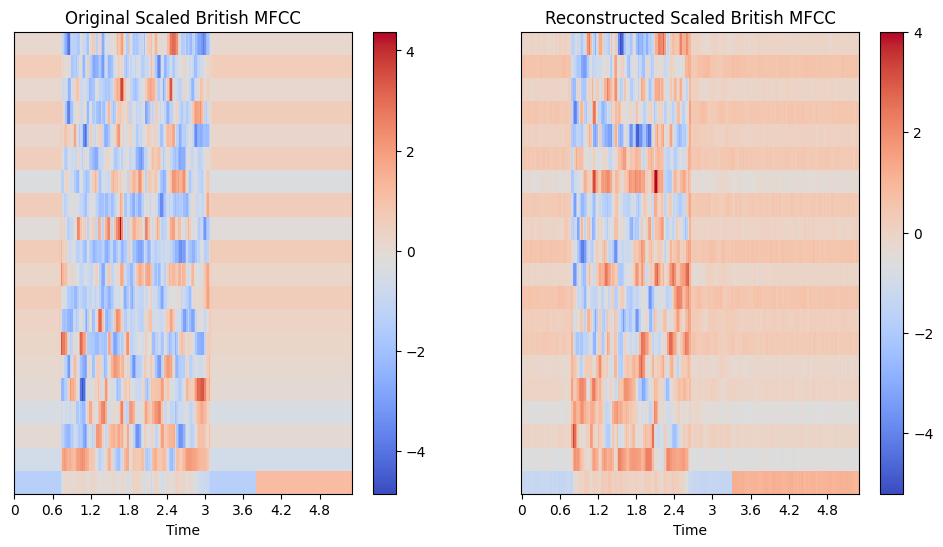

In [494]:
# Plot original waveform

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Scaled British MFCC')
librosa.display.specshow(test_mfcc_normalized.reshape(a,b),sr=sr, x_axis='time')
plt.colorbar()


# Plot reconstructed waveform
plt.subplot(1, 2, 2)
plt.title('Reconstructed Scaled British MFCC')
librosa.display.specshow(test_prediction_mfcc.reshape(a,b),sr=sr, x_axis='time')
plt.colorbar()

plt.show()


In [495]:
test_prediction_rescaled = test_prediction_mfcc*np.sqrt(y_var) + y_mean

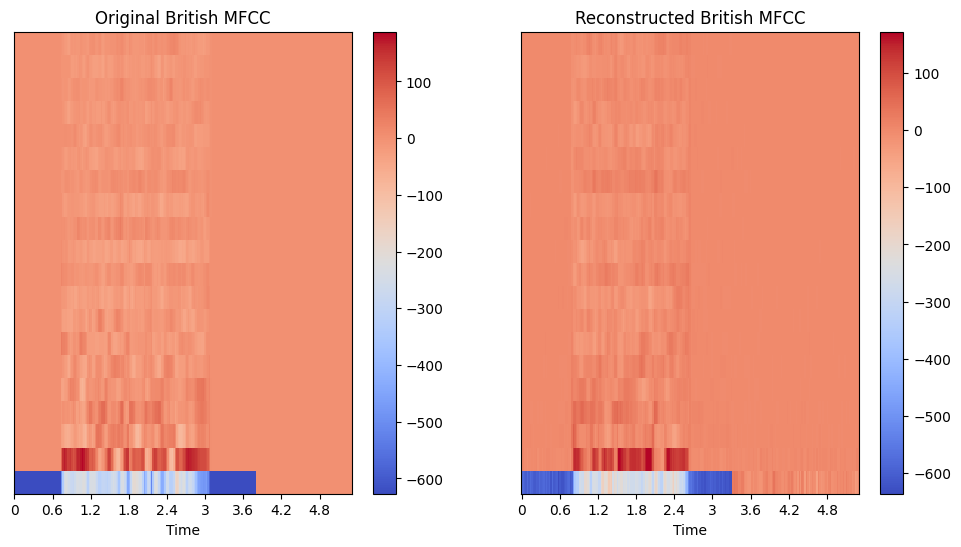

In [496]:
# Plot original waveform
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original British MFCC')
librosa.display.specshow(test_mfcc.reshape(a,b),sr=sr, x_axis='time')
plt.colorbar()


# Plot reconstructed waveform
plt.subplot(1, 2, 2)
plt.title('Reconstructed British MFCC')
librosa.display.specshow(test_prediction_rescaled.reshape(a,b),sr=sr, x_axis='time')
plt.colorbar()

plt.show()

In [497]:
test_prediction_audio = librosa.feature.inverse.mfcc_to_audio(test_prediction_rescaled, window=10, hop_length=500)

In [498]:
test_prediction_audio

array([ 0.00037336, -0.00108045, -0.00022888, ..., -0.01254801,
       -0.10853872,  0.14768314], dtype=float32)

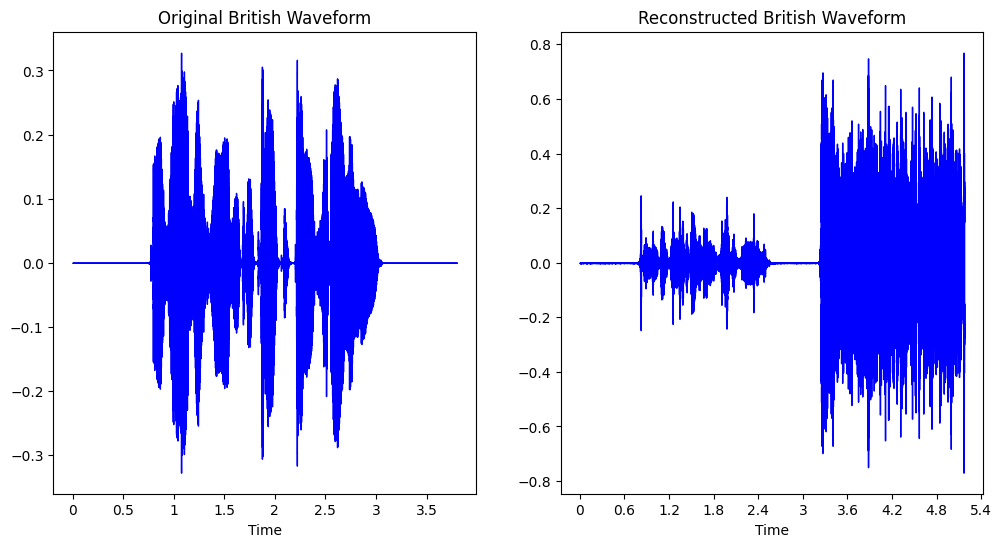

In [499]:
# Load original waveform
test_audio_original, sr = librosa.load(test_file, sr=sr)

# Plot original waveform
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original British Waveform')
librosa.display.waveshow(test_audio_original, sr=sr, color='blue')

# Plot reconstructed waveform
plt.subplot(1, 2, 2)
plt.title('Reconstructed British Waveform')
librosa.display.waveshow(test_prediction_audio, sr=sr, color='blue')
plt.show()

In [500]:
sf.write('test_audio_predicted.wav', test_prediction_audio, sr)

In [501]:
sf.write('test_audio_original.wav', test_audio_original, sr)